### 1. Preliminaries

In [1]:
import glob

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *
set_seed(42)

competition = 'paddy-doctor-diseases-v2'
path = setup_comp(competition, install='fastai "timm>=0.6.2.dev0"')

# train images
train_path = path / 'train_images'
train_files = get_image_files(train_path)

# test images
test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()

# train labels
train_df = pd.read_csv(path / 'train.csv')
print(train_df.shape)
train_df.label.value_counts()

(12980, 4)


normal                      1924
blast                       1881
hispa                       1720
tungro                      1561
white_stem_borer            1019
brown_spot                  1004
leaf_roller                  876
downy_mildew                 694
yellow_stem_borer            613
bacterial_leaf_blight        518
bacterial_leaf_streak        405
black_stem_borer             405
bacterial_panicle_blight     360
Name: label, dtype: int64

### 2. Dataloaders

In [2]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(train_path)

In [3]:
dls = ImageDataLoaders.from_folder(
    train_path, 
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

### 3. Model training

In [4]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

And that's it, 16 epochs to get the best baseline for the price 

In [5]:
learn.fine_tune(50, 0.005)
#learn.fine_tune(2, 0.005)

epoch,train_loss,valid_loss,error_rate,time
0,1.810568,1.089132,0.344376,02:46


epoch,train_loss,valid_loss,error_rate,time
0,0.769216,0.448270,0.135978,02:26
1,0.441168,0.284911,0.091294,02:26
2,0.310508,0.219787,0.065871,02:30
3,0.235165,0.237995,0.065485,02:29
4,0.209770,0.195346,0.048151,02:27
5,0.222626,0.214053,0.066256,02:29
6,0.210355,0.269286,0.077042,02:27
7,0.237884,0.231007,0.067797,02:27
8,0.235398,0.312522,0.083205,02:28
9,0.211179,0.240968,0.067411,02:28


### 4. Predictions

In [6]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0212)

In [7]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0208)

#### Predictions on test set

In [8]:
# test images
test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()
test_classes = [f.parent.name for f in test_files]

probs, _ = learn.tta(dl=dls.test_dl(test_files))
preds = probs.argmax(dim=1)
pred_classes = dls.vocab[preds]

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

cls_report = classification_report(test_classes, pred_classes, 
                                   digits=5)
print(cls_report)
acc = accuracy_score(test_classes, pred_classes)

                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.96947   0.97692   0.97318       130
   bacterial_leaf_streak    0.95146   0.98000   0.96552       100
bacterial_panicle_blight    1.00000   0.96667   0.98305        90
        black_stem_borer    0.98925   0.91089   0.94845       101
                   blast    0.97028   0.97234   0.97131       470
              brown_spot    0.98381   0.96047   0.97200       253
            downy_mildew    0.95954   0.95402   0.95677       174
                   hispa    0.96759   0.96984   0.96871       431
             leaf_roller    0.97727   0.98174   0.97950       219
                  normal    0.97951   0.99376   0.98658       481
                  tungro    0.98446   0.97436   0.97938       390
        white_stem_borer    0.95833   0.99606   0.97683       254
       yellow_stem_borer    1.00000   0.98684   0.99338       152

                accuracy                        0.97504      3245
        

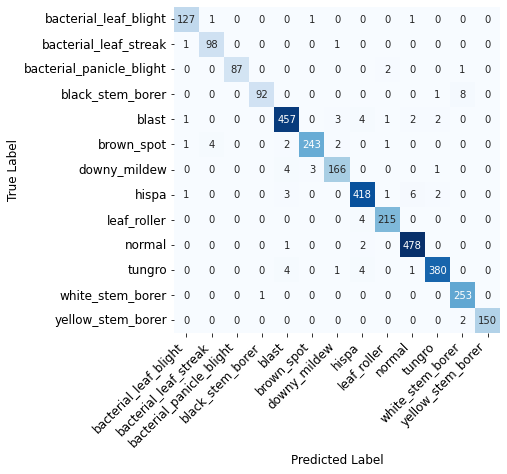

[[127   1   0   0   0   1   0   0   0   1   0   0   0]
 [  1  98   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0  87   0   0   0   0   0   2   0   0   1   0]
 [  0   0   0  92   0   0   0   0   0   0   1   8   0]
 [  1   0   0   0 457   0   3   4   1   2   2   0   0]
 [  1   4   0   0   2 243   2   0   1   0   0   0   0]
 [  0   0   0   0   4   3 166   0   0   0   1   0   0]
 [  1   0   0   0   3   0   0 418   1   6   2   0   0]
 [  0   0   0   0   0   0   0   4 215   0   0   0   0]
 [  0   0   0   0   1   0   0   2   0 478   0   0   0]
 [  0   0   0   0   4   0   1   4   0   1 380   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0 253   0]
 [  0   0   0   0   0   0   0   0   0   0   0   2 150]]


In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

class_names = dls.vocab
plot_heatmap(test_classes, pred_classes, class_names, ax, title="Resnet34")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(test_classes, pred_classes)
print(cm)

In [11]:
temp = pd.DataFrame({"y_true":test_classes,
                      "y_pred":pred_classes})
temp.to_csv('result.csv', index=False)
temp

,y_true,y_pred
0,bacterial_leaf_blight,bacterial_leaf_blight
1,bacterial_leaf_blight,normal
2,bacterial_leaf_blight,bacterial_leaf_blight
3,bacterial_leaf_blight,bacterial_leaf_blight
4,bacterial_leaf_blight,bacterial_leaf_blight
...,...,...
3240,yellow_stem_borer,yellow_stem_borer
3241,yellow_stem_borer,yellow_stem_borer
3242,yellow_stem_borer,yellow_stem_borer
3243,yellow_stem_borer,yellow_stem_borer


#### Acknowledgements
1. https://www.kaggle.com/code/fmussari/fast-resnet34-with-fastai
